In [52]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sys, os
np.random.seed(1337)  # for reproducibility
from keras.datasets import cifar10
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
import keras.layers
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.regularizers import l2
sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

In [32]:
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())
!nvidia-smi

Backend:        tensorflow
Data format:    channels_last
Available GPUS: []
/bin/sh: nvidia-smi: command not found


In [33]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

In [66]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#y_train = y_train.ravel()
#y_test = y_test.ravel()
print('train:',X_train.shape, y_train.shape)
print('test:',X_test.shape, y_test.shape)

train: (50000, 32, 32, 3) (50000, 1)
test: (10000, 32, 32, 3) (10000, 1)


In [67]:
nb_classes = len(set(y_train.ravel()))
print('n classes:', nb_classes)

n classes: 10


In [68]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

In [69]:
testing = True
if testing:
    n_samples = 500
    X_train = X_train[:n_samples]
    y_train = y_train[:n_samples]
    n_samples_test = 100
    X_test = X_test[:n_samples_test]
    y_test = y_test[:n_samples_test]

In [63]:
y_train_oh = np_utils.to_categorical(y_train, nb_classes)
y_test_oh = np_utils.to_categorical(y_test, nb_classes)

This notebook contains a Keras implementation of Huang et al.'s [DenseNet](https://arxiv.org/abs/1608.06993)

Our motivation behind studying DenseNet is because of how well it works with limited data.

DenseNet beats state-of-the-art results on CIFAR-10/CIFAR-100 w/ and w/o data augmentation, but the performance increase is most pronounced w/o data augmentation.

Compare to FractalNet, state-of-the-art on both datasets:
* CIFAR-10: ~ 30 % performance increase w/ DenseNet
* CIFAR-100: ~ 30 % performance increase w/ DenseNet

That increase is motivation enough.

So what is a DenseNet?

Put simply, DenseNet is a Resnet where we replace addition with concatenation.

## Idea

Recall that in broad terms, a Resnet is a Convnet that uses residual block structures.

These "blocks" work as follows:
* Let L<sub>t</sub> be the input layer to block
* Perform conv layer transformations/activations on L<sub>t</sub>, denote by f(<sub>t</sub>)
* Call output layer of block L<sub>t+1</sub>
* Define L<sub>t+1</sub> = f(L<sub>t</sub>)+ L<sub>t</sub>  
    * That is, total output is the conv layer outputs plus the original input
* We call residual block b.c. f(L<sub>t</sub>)=L<sub>t+1</sub> - L<sub>t</sub>, the residual
    

As mentioned, the difference w/ DenseNet is instead of adding L<sub>t</sub> to L<sub>t+1</sub>, it is being concatenated.

As with Resnet, DenseNet consists of multiple blocks.
Therefore, there is a recursive relationship across blocks:
* Block B<sub>i</sub> takes as input the ouput of block B<sub>i-1</sub> concatenated with the input of B<sub>i-1</sub>
* The input to B<sub>i-1</sub> is the ouput of block B<sub>i-2</sub> concatenated with the input of B<sub>i-2</sub>
* So on and so forth

The number of filters added to each layer needs to be monitored, given that the input space for each block keeps growing.

Huang et al. calls the # of filters added at each layer the *growth rate*, and appropriately denotes this number with the related letter *k*.

## Densenet

### The pieces

Let's make some helper functions for piecing together our network using Keras' Functional API.

These components should all be familiar to you:
* Relu activation
* Dropout regularization
* Batch-normalization

In [43]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(axis=-1)(x)
def relu_bn(x): return relu(bn(x))

Convolutional layer:
* L2 Regularization
* 'same' border mode returns same width/height
* Pass output through Dropout


In [44]:
def conv(x, nf, sz, wd, p):
    x = Conv2D(nf, (sz, sz), kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(wd))(x)
    return dropout(x,p)

Define ConvBlock as sequence:
* Batchnorm
* ReLU Activation
* Conv layer (conv w/ Dropout)

The authors also use something called a *bottleneck* layer to reduce dimensionality of inputs. 

Recall that the filter space dimensionality grows at each block. The input dimensionality will determine the dimensionality of your convolution weight matrices, i.e. # of parameters.

At size 3x3 or larger, convolutions can become extremely costly and # of parameters can increase quickly as a function of the input feature (filter) space. Therefore, a smart approach is to reduce dimensionality of filters by using a 1x1 convolution w/ smaller # of filters before the larger convolution.

Bottleneck consists of:
* 1x1 conv
* Compress # of filters into growth factor `nf` * 4
* Batchnorm -> ReLU

In [45]:
def conv_block(x, nf, bottleneck=False, p=None, wd=0):
    x = relu_bn(x)
    if bottleneck: x = relu_bn(conv(x, nf * 4, 1, wd, p))
    return conv(x, nf, 3, wd, p)

Now we can define the dense block:
* Take given input `x`
* Pass through a conv block for output `b`
* Concatenate input `x` and conv block output `b`
* Set concatenation as new input `x` for next block
* Repeat

In [46]:
def dense_block(x, nb_layers, growth_rate, bottleneck=False, p=None, wd=0):
    if bottleneck: nb_layers //= 2
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        x = keras.layers.concatenate([x,b],axis=-1)
    return x

As typical for CV architectures, we'll do some pooling after computation.

We'll define this unit as the transition block, and we'll put one between each dense block.

Aside from BN -> ReLU and Average Pooling, there is also an option for filter *compression* in this block. This is simply feature reduction via 1x1 conv as discussed before, where the new # of filters is a percentage of the incoming # of filters.

Together with bottleneck, compression has been shown to improve performance and computational efficiency of DenseNet architectures. (the authors call this DenseNet-BC)

In [47]:
def transition_block(x, compression=1.0, p=None, wd=0):
    nf = int(x.get_shape().as_list()[-1] * compression)
    x = relu_bn(x)
    x = conv(x, nf, 1, wd, p)
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

### Build the DenseNet model

We've now defined all the building blocks (literally) to put together a DenseNet.

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: total number of layers 
    - Includes 4 extra non-block layers
        - 1 input conv, 3 output layers
- nb_block: number of dense blocks (generally = 3). 
    - NOTE: Layers / block are evenly allocated. Therefore nb_block must be a factor of (Depth - 4)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- bottleneck: add bottleneck blocks
- Compression: Filter compression factor in transition blocks.
- p: dropout rate
- wd: weight decay
- activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'. Note that if sigmoid is used, classes must be 1.

Returns: keras tensor with nb_layers of conv_block appended

From start to finish, this generates:
* Conv input layer
* Alternate between Dense/Transition blocks `nb_block` times, ommitting Transition block after last Dense block
    * Each Dense block has `(Depth-4)/nb_block` layers
* Pass final Dense block to BN -> ReLU
* Global Avg Pooling
* Dense layer w/ desired output activation

In [54]:
def create_dense_net(nb_classes, img_input, depth=40, nb_block=3, 
     growth_rate=12, nb_filter=16, bottleneck=False, compression=1.0, p=None, wd=0, activation='softmax'):
    
    assert activation == 'softmax' or activation == 'sigmoid'
    assert (depth - 4) % nb_block == 0
    nb_layers_per_block = int((depth - 4) / nb_block)
    nb_layers = [nb_layers_per_block] * nb_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    for i,block in enumerate(nb_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        if i != len(nb_layers)-1:
            x = transition_block(x, compression=compression, p=p, wd=wd)

    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    return Dense(nb_classes, activation=activation, kernel_regularizer=l2(wd))(x)

### Train

Now we can test it out on CIFAR-10.

In [70]:
input_shape = (32,32,3)
img_input = Input(shape=input_shape)
x = create_dense_net(10, img_input, depth=100, nb_filter=16, compression=0.5, 
                     bottleneck=True, p=0.2, wd=1e-4)

model = Model(img_input, x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_345 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_339 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
activation_339 (Activation)  (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_346 (Conv2D)          (None, 32, 32, 48)        816       
_________________________________________________________________
dropout_336 (Dropout)        (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_340 (Bat (None, 32, 32, 48)        192       
__________

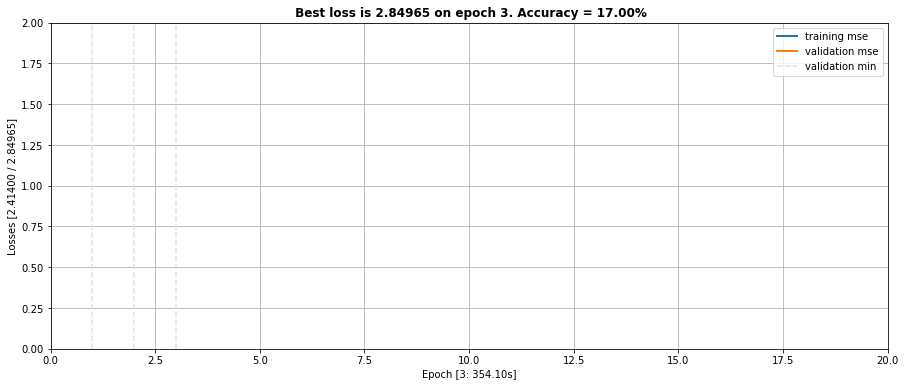

In [ ]:
model_name = '../../models/cifar_densenet'
fit_params = {
    'model_name': model_name,
    'loss':       'sparse_categorical_crossentropy',
    'opt':        RMSprop(),
    'batch_size': 64, 
    'nepochs':    20,
    'patience':   5,
    'ploss':      2.,
    'reset':      True,
}

model_trained,_ = train_network(model, X_train, y_train, X_test, y_test, **fit_params);

In [18]:
model.compile(loss='sparse_categorical_crossentropy', 
      optimizer=keras.optimizers.SGD(0.1, 0.9, nesterov=True), metrics=["accuracy"])

In [19]:
parms = {'verbose': 2, 'callbacks': [TQDMNotebookCallback()]}

In [20]:
K.set_value(model.optimizer.lr, 0.1)

This will likely need to run overnight + lr annealing...

In [21]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
561s - loss: 1.9801 - acc: 0.4810 - val_loss: 2.0473 - val_acc: 0.5045
Epoch 2/20
556s - loss: 1.4368 - acc: 0.6571 - val_loss: 1.8446 - val_acc: 0.5864
Epoch 3/20
547s - loss: 1.2204 - acc: 0.7122 - val_loss: 1.3181 - val_acc: 0.6696
Epoch 4/20
556s - loss: 1.0634 - acc: 0.7547 - val_loss: 1.3620 - val_acc: 0.6658
Epoch 5/20
560s - loss: 0.9536 - acc: 0.7829 - val_loss: 2.6235 - val_acc: 0.4702
Epoch 6/20
557s - loss: 0.8835 - acc: 0.8025 - val_loss: 2.4969 - val_acc: 0.4981
Epoch 7/20
551s - loss: 0.8293 - acc: 0.8155 - val_loss: 1.1944 - val_acc: 0.7281
Epoch 8/20
551s - loss: 0.7949 - acc: 0.8244 - val_loss: 1.1396 - val_acc: 0.7366
Epoch 9/20
551s - loss: 0.7620 - acc: 0.8340 - val_loss: 1.9196 - val_acc: 0.5916
Epoch 10/20
551s - loss: 0.7472 - acc: 0.8389 - val_loss: 2.6207 - val_acc: 0.4900
Epoch 11/20
550s - loss: 0.7251 - acc: 0.8449 - val_loss: 1.4957 - val_acc: 0.6859
Epoch 12/20
551s - loss: 0.7117 - acc: 0.8503 

In [22]:
K.set_value(model.optimizer.lr, 0.01)

In [23]:
model.fit(x_train, y_train, 64, 4, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
550s - loss: 0.5463 - acc: 0.9128 - val_loss: 0.5737 - val_acc: 0.9033
Epoch 2/4
551s - loss: 0.4833 - acc: 0.9311 - val_loss: 0.5695 - val_acc: 0.9033
Epoch 3/4
551s - loss: 0.4575 - acc: 0.9366 - val_loss: 0.5590 - val_acc: 0.9051
Epoch 4/4
550s - loss: 0.4361 - acc: 0.9429 - val_loss: 0.5656 - val_acc: 0.9048



In [24]:
K.set_value(model.optimizer.lr, 0.1)

In [26]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples

Epoch 1/20
551s - loss: 0.6589 - acc: 0.8728 - val_loss: 1.3259 - val_acc: 0.6935
Epoch 2/20
551s - loss: 0.6510 - acc: 0.8766 - val_loss: 0.9672 - val_acc: 0.7880
Epoch 3/20
551s - loss: 0.6508 - acc: 0.8784 - val_loss: 1.1104 - val_acc: 0.7581
Epoch 4/20
551s - loss: 0.6462 - acc: 0.8793 - val_loss: 1.0601 - val_acc: 0.7877
Epoch 5/20
550s - loss: 0.6456 - acc: 0.8816 - val_loss: 0.9799 - val_acc: 0.7876
Epoch 6/20
551s - loss: 0.6427 - acc: 0.8830 - val_loss: 0.9377 - val_acc: 0.8028
Epoch 7/20
551s - loss: 0.6409 - acc: 0.8837 - val_loss: 1.8484 - val_acc: 0.5932
Epoch 8/20
551s - loss: 0.6378 - acc: 0.8831 - val_loss: 1.1806 - val_acc: 0.7420
Epoch 9/20
550s - loss: 0.6381 - acc: 0.8843 - val_loss: 1.0799 - val_acc: 0.7774
Epoch 10/20
551s - loss: 0.6344 - acc: 0.8870 - val_loss: 0.9114 - val_acc: 0.8163
Epoch 11/20
561s - loss: 0.6394 - acc: 0.8858 - val_loss: 0.9710 - val_acc: 0.7982
Epoch 12/20
560s - loss: 0.6367 - acc: 0.8863

In [27]:
K.set_value(model.optimizer.lr, 0.01)

In [28]:
model.fit(x_train, y_train, 64, 40, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
556s - loss: 0.5141 - acc: 0.9320 - val_loss: 0.5652 - val_acc: 0.9165
Epoch 2/40
560s - loss: 0.4530 - acc: 0.9477 - val_loss: 0.5451 - val_acc: 0.9199
Epoch 3/40
560s - loss: 0.4290 - acc: 0.9546 - val_loss: 0.5409 - val_acc: 0.9188
Epoch 4/40
559s - loss: 0.4101 - acc: 0.9584 - val_loss: 0.5259 - val_acc: 0.9224
Epoch 5/40
549s - loss: 0.3934 - acc: 0.9620 - val_loss: 0.5365 - val_acc: 0.9198
Epoch 6/40
551s - loss: 0.3813 - acc: 0.9631 - val_loss: 0.5150 - val_acc: 0.9209
Epoch 7/40
556s - loss: 0.3685 - acc: 0.9644 - val_loss: 0.5238 - val_acc: 0.9197
Epoch 8/40
556s - loss: 0.3565 - acc: 0.9668 - val_loss: 0.5188 - val_acc: 0.9204
Epoch 9/40
555s - loss: 0.3430 - acc: 0.9693 - val_loss: 0.5078 - val_acc: 0.9206
Epoch 10/40
553s - loss: 0.3325 - acc: 0.9707 - val_loss: 0.5107 - val_acc: 0.9191
Epoch 11/40
556s - loss: 0.3220 - acc: 0.9721 - val_loss: 0.5091 - val_acc: 0.9191
Epoch 12/40
556s - loss: 0.3121 - acc: 0.9738 

In [29]:
K.set_value(model.optimizer.lr, 0.001)

In [30]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
547s - loss: 0.1885 - acc: 0.9845 - val_loss: 0.4287 - val_acc: 0.9256
Epoch 2/20
548s - loss: 0.1772 - acc: 0.9886 - val_loss: 0.4198 - val_acc: 0.9279
Epoch 3/20
547s - loss: 0.1734 - acc: 0.9901 - val_loss: 0.4181 - val_acc: 0.9283
Epoch 4/20
547s - loss: 0.1706 - acc: 0.9910 - val_loss: 0.4188 - val_acc: 0.9280
Epoch 5/20
548s - loss: 0.1679 - acc: 0.9918 - val_loss: 0.4127 - val_acc: 0.9298
Epoch 6/20
548s - loss: 0.1670 - acc: 0.9921 - val_loss: 0.4159 - val_acc: 0.9301
Epoch 7/20
548s - loss: 0.1650 - acc: 0.9926 - val_loss: 0.4139 - val_acc: 0.9300
Epoch 8/20
547s - loss: 0.1631 - acc: 0.9933 - val_loss: 0.4087 - val_acc: 0.9304
Epoch 9/20
548s - loss: 0.1619 - acc: 0.9934 - val_loss: 0.4150 - val_acc: 0.9302
Epoch 10/20
547s - loss: 0.1609 - acc: 0.9939 - val_loss: 0.4154 - val_acc: 0.9294
Epoch 11/20
547s - loss: 0.1611 - acc: 0.9933 - val_loss: 0.4102 - val_acc: 0.9310
Epoch 12/20
547s - loss: 0.1584 - acc: 0.9943 

In [31]:
K.set_value(model.optimizer.lr, 0.01)

In [32]:
model.fit(x_train, y_train, 64, 10, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
548s - loss: 0.1819 - acc: 0.9842 - val_loss: 0.4929 - val_acc: 0.9092
Epoch 2/10
547s - loss: 0.2018 - acc: 0.9751 - val_loss: 0.5761 - val_acc: 0.8880
Epoch 3/10
548s - loss: 0.2046 - acc: 0.9742 - val_loss: 0.5411 - val_acc: 0.8950
Epoch 4/10
548s - loss: 0.2008 - acc: 0.9765 - val_loss: 0.5607 - val_acc: 0.8957
Epoch 5/10
548s - loss: 0.1956 - acc: 0.9778 - val_loss: 0.4991 - val_acc: 0.9049
Epoch 6/10
548s - loss: 0.1996 - acc: 0.9760 - val_loss: 0.4714 - val_acc: 0.9112
Epoch 7/10
548s - loss: 0.1947 - acc: 0.9779 - val_loss: 0.5921 - val_acc: 0.8855
Epoch 8/10
547s - loss: 0.1958 - acc: 0.9770 - val_loss: 0.5096 - val_acc: 0.9058
Epoch 9/10
547s - loss: 0.1976 - acc: 0.9754 - val_loss: 0.5129 - val_acc: 0.9041
Epoch 10/10
548s - loss: 0.1940 - acc: 0.9767 - val_loss: 0.5693 - val_acc: 0.8869



In [33]:
K.set_value(model.optimizer.lr, 0.001)

In [34]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
548s - loss: 0.1879 - acc: 0.9801 - val_loss: 0.4073 - val_acc: 0.9270
Epoch 2/20
548s - loss: 0.1631 - acc: 0.9893 - val_loss: 0.4040 - val_acc: 0.9265
Epoch 3/20
547s - loss: 0.1601 - acc: 0.9905 - val_loss: 0.4007 - val_acc: 0.9295
Epoch 4/20
547s - loss: 0.1560 - acc: 0.9919 - val_loss: 0.4016 - val_acc: 0.9294
Epoch 5/20
548s - loss: 0.1540 - acc: 0.9921 - val_loss: 0.3988 - val_acc: 0.9293
Epoch 6/20
547s - loss: 0.1529 - acc: 0.9926 - val_loss: 0.4013 - val_acc: 0.9283
Epoch 7/20
548s - loss: 0.1497 - acc: 0.9937 - val_loss: 0.3984 - val_acc: 0.9312
Epoch 8/20
548s - loss: 0.1508 - acc: 0.9929 - val_loss: 0.3993 - val_acc: 0.9304
Epoch 9/20
547s - loss: 0.1486 - acc: 0.9937 - val_loss: 0.3988 - val_acc: 0.9303
Epoch 10/20
547s - loss: 0.1471 - acc: 0.9938 - val_loss: 0.3978 - val_acc: 0.9302
Epoch 11/20
547s - loss: 0.1460 - acc: 0.9942 - val_loss: 0.3945 - val_acc: 0.9306
Epoch 12/20
547s - loss: 0.1453 - acc: 0.9943 

And we're able to replicate their state-of-the-art results!

In [35]:
%time model.save_weights('models/93.h5')

CPU times: user 31.1 s, sys: 452 ms, total: 31.6 s
Wall time: 31.1 s


## End